## Part 1: Import Libraries

In this section, we import the necessary libraries.

**Key Libraries:**
* `LogisticRegression`: A linear model for classification. It estimates probabilities using a logistic function.
* `StandardScaler`: **Crucial.** Logistic Regression uses regularization (Ridge/Lasso), which penalizes large coefficients. Scaling ensures all features are treated equally.
* `GridSearchCV`: For finding the optimal Regularization parameter (`C`).

In [1]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Scikit-Learn Models & Tools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, roc_auc_score, recall_score, precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Part 2: Data Preparation

To ensure a fair comparison with SVM and Random Forest:

1.  **Merge & Split:** We load both original files, merge them, and re-split into **Train (70%)**, **Validation (15%)**, and **Test (15%)**.
2.  **Leakage Prevention:** We drop `id` and `attack_cat`.
3.  **Encoding Strategy (One-Hot):**
    * Logistic Regression treats input features as numerical values multiplied by coefficients ($w_1x_1 + w_2x_2 + ...$).
    * We **must** use One-Hot Encoding for categorical variables (`proto`, `service`, `state`) to prevent the model from assuming a mathematical order (e.g., that "TCP > UDP").

In [2]:
def load_and_prep_data():
    # Update with your paths
    train_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_training-set.csv'
    test_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_testing-set.csv'

    #  Local ENV file path
    test_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_testing-set.csv'
    train_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_training-set.csv'
    

    print("Loading data...")
    df_train_orig = pd.read_csv(train_path)
    df_test_orig = pd.read_csv(test_path)

    # 1. Combine Datasets (Standardized Strategy)
    df_full = pd.concat([df_train_orig, df_test_orig], axis=0).reset_index(drop=True)

    # 2. Drop Forbidden Columns
    drop_cols = ['id', 'label', 'attack_cat']
    X = df_full.drop(drop_cols, axis=1)
    y = df_full['label']

    # 3. Stratified Split: Train (70%) and Temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 4. Split Temp into Validation (15%) and Test (15%)
    # 0.5 * 30% = 15%
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # Now X_train, X_val, X_test/ y_train, y_val, y_test available
    
    # 5. Encoding: ONE-HOT (Required for Logistic Regression)
    # RF uses LabelEncoding, but SVM needs One-Hot.
    categorical_cols = ['proto', 'service', 'state'] # attack_cat removed since already dropped
    # ONE-HOT Encoding each train/test/validation data
    X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    
    # reindex based on X_train after OHE
    X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    print(f"Features after One-Hot Encoding: {len(X.columns)}")
    print("-" * 50)

    print(f"Data Loaded and Split:")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_and_prep_data()

Loading data...
Features after One-Hot Encoding: 42
--------------------------------------------------
Data Loaded and Split:
Train: (180371, 190), Val: (38651, 190), Test: (38651, 190)


## Part 3: Custom Feature Engineering

We generate the same custom features used in the other models to maintain consistency:

1.  **Packet Ratio (`pkt_ratio`):** $(spkts + 1) / (dpkts + 1)$
2.  **TTL Gap (`ttl_gap`):** $|sttl - dttl|$

In [3]:
class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, use_extra_features=True):
        self.use_extra_features = use_extra_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        if self.use_extra_features:
            # pkt_ratio
            if 'spkts' in X.columns and 'dpkts' in X.columns:
                X_transformed['pkt_ratio'] = (X_transformed['spkts'] + 1) / (X_transformed['dpkts'] + 1)

            # ttl_gap
            if 'sttl' in X.columns and 'dttl' in X.columns:
                X_transformed['ttl_gap'] = abs(X_transformed['sttl'] - X_transformed['dttl'])
        return X_transformed

## Part 4: Model Training & Tuning

We use a **Pipeline** to ensure correct processing:
1.  **Feature Engineering:** Add new features.
2.  **Scaling (`StandardScaler`):** **Mandatory** for Logistic Regression.
3.  **Model (`LogisticRegression`):** We use the `lbfgs` solver which is robust and supports L2 regularization.

**Hyperparameter Tuning:**
We tune:
* **`C` (Inverse Regularization Strength):** Smaller values specify stronger regularization (to prevent overfitting).
* **`use_extra_features`**: To verify if our feature engineering helps.

In [4]:
def train_and_tune_lr(X_train, y_train, X_val, y_val):
    print("Starting Grid Search for Logistic Regression...")
    start_time = time.time()

    # Pipeline
    pipeline = Pipeline([
        ('custom_transformer', CustomFeatureTransformer()),
        ('scaler', StandardScaler()), # REQUIRED for LR
        ('lr', LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs'))
    ])

    # Parameters to tune
    param_grid = {
        'custom_transformer__use_extra_features': [True, False],
        'lr__C': [0.01, 0.1, 1, 10] # Regularization strength
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring='f1',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # --- Print Results (Aligned Format) ---
    results_df = pd.DataFrame(grid_search.cv_results_)
    relevant_results = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    relevant_results = relevant_results.sort_values(by='rank_test_score')

    print("\n--- All Hyperparameter Combinations (Sorted by F1-Score) ---")
    pd.set_option('display.max_colwidth', None)
    print(relevant_results.to_string(index=False))

    # Validate
    val_predictions = grid_search.best_estimator_.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions)

    print(f"\nGrid Search Complete in {time.time() - start_time:.2f} seconds.")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Validation F1-Score: {val_f1:.4f}")

    return grid_search.best_estimator_

best_lr_model = train_and_tune_lr(X_train, y_train, X_val, y_val)

Starting Grid Search for Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- All Hyperparameter Combinations (Sorted by F1-Score) ---
                                                          params  mean_test_score  std_test_score  rank_test_score
   {'custom_transformer__use_extra_features': True, 'lr__C': 10}         0.928900        0.000530                1
  {'custom_transformer__use_extra_features': False, 'lr__C': 10}         0.928415        0.000644                2
    {'custom_transformer__use_extra_features': True, 'lr__C': 1}         0.928211        0.000550                3
  {'custom_transformer__use_extra_features': True, 'lr__C': 0.1}         0.927183        0.000461                4
   {'custom_transformer__use_extra_features': False, 'lr__C': 1}         0.927116        0.000543                5
 {'custom_transformer__use_extra_features': False, 'lr__C': 0.1}         0.925683        0.000377                6
 {'custom_transformer__us

## Part 5: Final Evaluation

We evaluate the best Logistic Regression model on the held-out **Test Set**.

**Why Logistic Regression?**
It serves as an excellent baseline. It is fast, interpretable, and provides probability outputs naturally. If complex models like SVM or RF barely beat Logistic Regression, it suggests the problem might be linearly separable.


       FINAL EVALUATION ON TEST SET (Logistic Regression)

--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)     0.9330    0.7994    0.8610     13950
  Attack (1)     0.8952    0.9676    0.9300     24701

    accuracy                         0.9069     38651
   macro avg     0.9141    0.8835    0.8955     38651
weighted avg     0.9088    0.9069    0.9051     38651



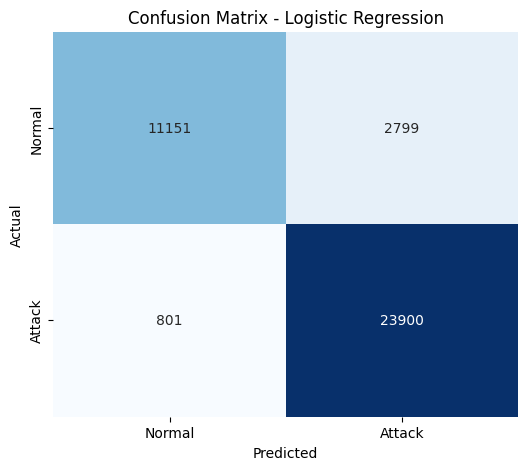

In [5]:
def evaluate_model(model, X_test, y_test):
    print("\n" + "=" * 60)
    print("       FINAL EVALUATION ON TEST SET (Logistic Regression)")
    print("=" * 60)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 1. Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Attack (1)'], digits=4))

    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Logistic Regression')
    plt.show()

evaluate_model(best_lr_model, X_test, y_test)